# Create project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [23]:
#Set sktlearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


## Custom Functions

In [8]:
def find_outliers_Z(data, verbose=True):
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    outliers = np.abs(stats.zscore(data))>3
    
    
    if verbose:
        n = len(outliers)
        print(f"- {outliers.sum():,} outliers found in {data.name} out of {n:,}\
              rows ({outliers.sum()/n*100:.2f}%) using Z-scores.")

    outliers = pd.Series(outliers, index=data.index, name=data.name)
    return outliers


def find_outliers_IQR(data, verbose=True):
    import pandas as pd
    import numpy as np
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        n = len(outliers)
    
    
        print(f"- {outliers.sum():,} outliers found in {data.name} out of {n:,}\
              rows ({outliers.sum()/n*100:.2f}%) using IQR.")
        
    outliers = pd.Series(outliers, index=data.index, name=data.name)
    return outliers



In [14]:
def remove_outliers(df_,method='iqr', subset=None, verbose=2):
    """Returns a copy of the input df with outleirs removed from all
    columns using the selected method (either 'iqr' or 'z'/'zscore')
    
    Arguments:
        df_ (Frame): Dataframe to copy and remove outleirs from
        method (str): Method of outlier removal. Options are 'iqr' or 'z' (default is 'iqr')
        subset (list or None): List of column names to remove outliers from. If None, uses all numeric columns.
        verbose (bool, int): If verbose==1, print only overall summary. If verbose==2, print detailed summary"""
    import pandas as pd
    ## Make a cope of input dataframe  
    df = df_.copy()
    
    ## Set verbose_func for calls to outleir funcs
    if verbose==2:
        verbose_func = True
    else:
        verbose_func=False
        
    ## Set outlier removal function and name
    if method.lower()=='iqr':
        find_outlier_func = find_outliers_IQR
        method_name = "IQR rule"
    elif 'z' in method.lower():
        find_outlier_func = find_outliers_Z
        method_name = 'Z_score rule'
    else:
        raise Exception('[!] Method must be either "iqr" or "z".')
        
    ## Set list of cols to remove outliers from
    if subset is None:
        col_list = df.select_dtypes('number').columns
    elif isinstance(subset,str):
        col_list = [subset]
    elif isinstance(subset, list):
        col_list = subset
    else:
        raise Exception("[!] subset must be None, a single string, or a list of strings.")
 ## Empty dict for both types of outliers
    outliers = {}

    ## Use both functions to see the comparison for # of outliers
    for col in col_list:
        idx_outliers = find_outlier_func(df[col],verbose=verbose_func)
        outliers[col] = idx_outliers

    
    ## Getting final df of all outliers to get 1 final T/F index
    outliers_combined = pd.DataFrame(outliers).any(axis=1)
    
    if verbose:
        n = len(outliers_combined)
        print(f"\n[i] Overall, {outliers_combined.sum():,} rows out of {n:,}\
        ({outliers_combined.sum()/n*100:.2f}%) were removed as outliers using {method_name}.")
    
    
    # remove_outliers 
    df_clean = df[~outliers_combined].copy()
    return df_clean

In [9]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [10]:
# get coefficients function
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs


In [11]:
# plot coefficients functions
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    fig= ax.get_figure()
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
#sns.plt.show()
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

In [12]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

# Load the Data

In [15]:
#create pandas dataframe
filename='Data/sales_predictions - sales_predictions (1).csv'
df = pd.read_csv(filename)

In [16]:
## Display the first (5) rows of the dataframe
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
## Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent \
{df.shape[1]-1} features and 1 target variable.')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


In [18]:
# display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Prepare the Data

In [19]:
# check for missing values
df.isna().sum()


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [20]:
# check for number of unique values in each column
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [21]:
# Fix the fat content row done in all projects
# fix the inconsistencies  in the "item_Fat_Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Explore the Data and Visuals

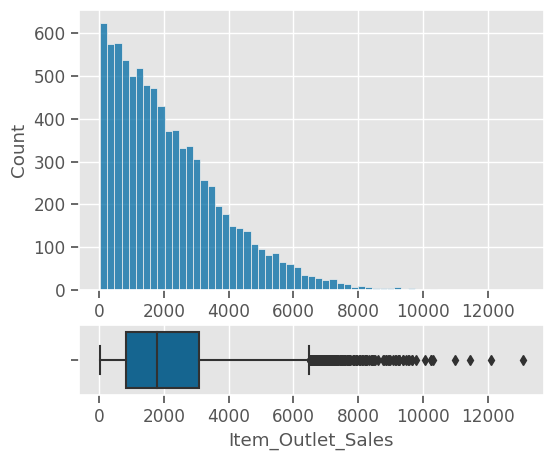

In [24]:
#create histogram and boxplot of target
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

# Model Validation Split

In [25]:
#Set target
target = 'Item_Outlet_Sales'
X = df.drop(columns = target)
y = df[target]

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1


## Preprocessing

In [26]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [27]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000256E9D5C4F0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000256E9D5CE20>)])

In [28]:
## make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Models

## Linear Regression

In [29]:
# instantiate the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Split,R^2,MAE,RMSE
Train,0.67,725.38,973.12
Test,"-1,958,224,537,042,239.25","4,365,931,899.79","77,721,793,710.35"


In [30]:
# get coefficients
coeffs = get_coefficients(lin_reg)
coeffs.head()

Item_Weight                 -2.414338e+00
Item_Visibility             -7.949584e+02
Item_MRP                    -1.107978e+01
Outlet_Establishment_Year   -1.760337e+09
Item_Identifier_DRA12        2.188858e+11
dtype: float64

In [31]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [32]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

Outlet_Location_Type_Tier 3   -23,257,681,116,380.1641
Outlet_Location_Type_Tier 1   -21,419,618,372,825.2656
Item_Identifier_FDH09          -6,319,555,156,111.4072
Item_Identifier_FDJ45          -6,319,555,156,065.3770
Item_Identifier_FDK45          -6,319,555,154,136.5098
Item_Identifier_FDF33          -6,319,555,153,621.1895
Item_Identifier_FDH21          -6,319,555,152,827.8652
Item_Identifier_FDI57          -6,319,555,150,650.1846
Item_Type_Seafood               5,969,477,146,125.3027
Outlet_Identifier_OUT013        6,611,813,700,238.7676
Outlet_Type_Grocery Store       8,393,005,830,527.7949
Outlet_Size_High                9,954,342,450,357.1074
Outlet_Identifier_OUT046       11,892,771,049,710.6484
Outlet_Size_Medium             14,536,567,023,831.8809
intercept                      15,302,931,823,265.5215
dtype: float64

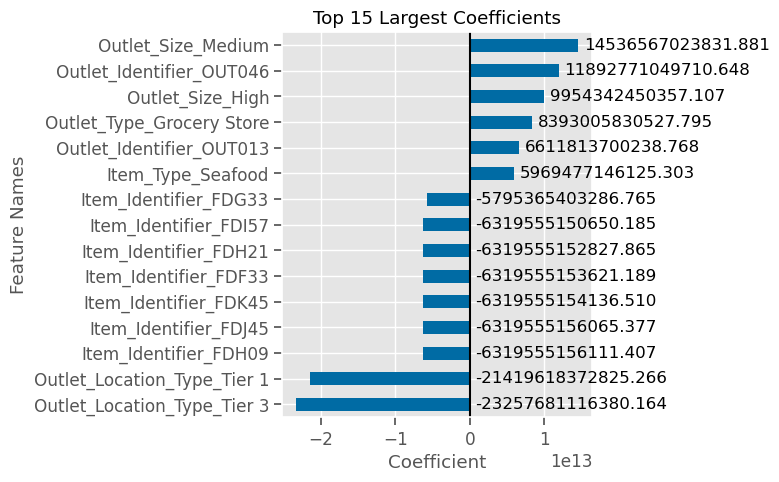

In [33]:
#plot coeffs with function
lr_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
fig.savefig('Images/Top 15 Coefficients with Linear Regression')

##  Random Forest

In [34]:
# instantiate the model, fit and evaluate
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,291.98,422.78
Test,0.56,817.74,"1,162.59"


In [35]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                       0.0302
Item_Visibility                   0.0578
Item_MRP                          0.4040
Outlet_Establishment_Year         0.0259
Item_Identifier_DRA12             0.0001
Item_Identifier_DRA24             0.0001
Item_Identifier_DRA59             0.0003
Item_Identifier_DRB01             0.0008
Item_Identifier_DRB13             0.0001
Item_Identifier_DRB24             0.0001
Item_Identifier_DRB25             0.0000
Item_Identifier_DRB48             0.0000
Item_Identifier_DRC01             0.0000
Item_Identifier_DRC12             0.0000
Item_Identifier_DRC13             0.0000
Item_Identifier_DRC24             0.0000
Item_Identifier_DRC25             0.0000
Item_Identifier_DRC27             0.0001
Item_Identifier_DRC36             0.0001
Item_Identifier_DRC49             0.0000
Item_Identifier_DRD01             0.0000
Item_Identifier_DRD12             0.0000
Item_Identifier_DRD13             0.0000
Item_Identifier_DRD15             0.0000
Item_Identifier_

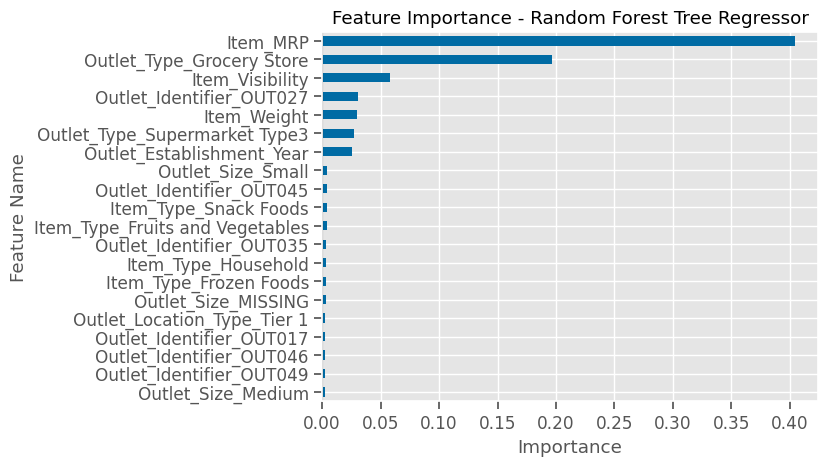

In [36]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
fig.savefig('Images/Feature Importance with Random Forest Regressor')

In [37]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                       0.0302
Item_Visibility                   0.0578
Item_MRP                          0.4040
Outlet_Establishment_Year         0.0259
Item_Identifier_DRA12             0.0001
Item_Identifier_DRA24             0.0001
Item_Identifier_DRA59             0.0003
Item_Identifier_DRB01             0.0008
Item_Identifier_DRB13             0.0001
Item_Identifier_DRB24             0.0001
Item_Identifier_DRB25             0.0000
Item_Identifier_DRB48             0.0000
Item_Identifier_DRC01             0.0000
Item_Identifier_DRC12             0.0000
Item_Identifier_DRC13             0.0000
Item_Identifier_DRC24             0.0000
Item_Identifier_DRC25             0.0000
Item_Identifier_DRC27             0.0001
Item_Identifier_DRC36             0.0001
Item_Identifier_DRC49             0.0000
Item_Identifier_DRD01             0.0000
Item_Identifier_DRD12             0.0000
Item_Identifier_DRD13             0.0000
Item_Identifier_DRD15             0.0000
Item_Identifier_

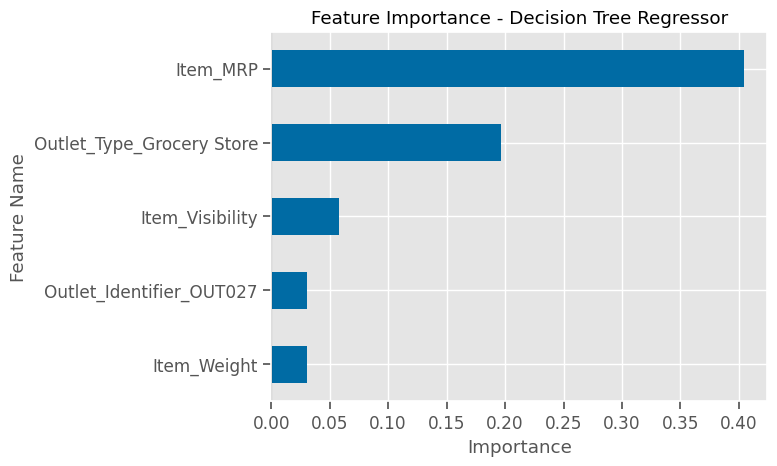

In [46]:
#save with 5
ax = importances.sort_values().tail(5).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance')
plt.savefig('Images/Feature Importance of Top 5 - Random Forest Regressor');

### Top 5 Important Features (used repeatedly by the model during the training process and does not indicate positive or negative impact)

- 1. Item MRP: suggest retail prices affects the sale
- 2. Outlet Type Grocery  affects the sales
- 3. Item visibility affects the sales
- 4. Item weight affects the sales
- 5. Outlet Type Supermarket affects  the sales

# Save to Joblib

In [39]:
# evaluate linear regression
evaluate_regression(lin_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.67,725.38,973.12
Test,"-1,958,224,537,042,239.25","4,365,931,899.79","77,721,793,710.35"


In [40]:
#evaluate random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,291.98,422.78
Test,0.56,817.74,"1,162.59"


In [41]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [42]:
#create folder
folder = "Models/"
os.makedirs(folder, exist_ok=True)


In [43]:
#create file
fname = folder+'grocerysales'
joblib.dump(export, fname)

['Models/grocerysales']

In [45]:
#check that it loaded
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])